In [12]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('once')

Functions

In [14]:
def sample_data(df, start_date):
  start_date = datetime.strptime(start_date, '%Y-%m-%d')
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def sample_data_with_train_window(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test=None):
  model_res = model.fit(disp=0)

  if "SARIMA" in model_name:
    return model_res.get_forecast(steps=forecast_horizon, exog=exog_data_test).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)

def save_results(results, config_name, date_start, forecast_horizon, iterations):
  df_predictions = pd.DataFrame(results)
  df_predictions.index = pd.date_range(start=date_start, periods=forecast_horizon*iterations, freq='h')

  df_predictions.to_csv(f'../Results/Whitebox/Forecasting/{config_name}.csv', header=False)

def save_runtime(runtime, config_name):
  try:
    df_runtime = pd.read_csv('../Results/Whitebox/Forecasting/whitebox_runtime.csv')
  except:
    df_runtime = pd.DataFrame(columns=['model', 'runtime'])

  new_row = {'model': config_name, 'runtime': runtime}
  df_runtime = pd.concat([df_runtime, pd.DataFrame([new_row])], ignore_index=True)
  df_runtime = df_runtime.sort_values(by=['model', 'runtime'], ascending=True).reset_index(drop=True)
  df_runtime.to_csv('../Results/Whitebox/Forecasting/whitebox_runtime.csv', index=False)

Initializing time series

In [15]:
# Consumption data
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv', sep=';')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

In [16]:
# El-spot prices
df2 = pd.read_csv('../Dataset/ELSpotPrices.csv', sep=';')
df2['HourDK'] = pd.to_datetime(df2['HourDK'])
df2['SpotPriceDKK'] = df2['SpotPriceDKK'].str.replace(",", ".").astype(float)
df2.index = df2['HourDK']
df2 = df2.iloc[1:] # remove first row, since the measurement at that time is not present in other dataset
df2.drop(columns=['HourUTC', 'HourDK', 'PriceArea', 'SpotPriceEUR'], inplace=True)

In [17]:
# at 196
date_start = '2023-11-01'
window_train_size = 336 #hours
forecast_horizon = 24 #hours
pos = 196

data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
iterations = 0
max_iterations = 366

while len(data) > window_train_size + forecast_horizon:
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
  data = data.iloc[forecast_horizon:]
  if iterations == 194:
    # print(data_train)
    # print(data_test)
    # data_train.to_csv('data_train2.csv')
    break
  iterations += 1
  # print(f'Iteration {iterations}/{max_iterations}')

  

Runs a model in Sliding Window forecasting style

In [21]:
model_name = 'SARIMAX'
date_start = '2023-11-01'
window_train_size = 17520 #hours
forecast_horizon = 8760 #hours
# 336_24, 1440_336, 17520_8760

config_name = f'{model_name}_{window_train_size}_{forecast_horizon}'

warnings.filterwarnings("ignore")

start_time = time.time()

data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
exog_data = sample_data_with_train_window(df2, date_start, window_train_size)
results = np.array([])
iterations = 0

scaler = MinMaxScaler()

while len(data) > window_train_size + forecast_horizon:
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
  exog_data_train, exog_data_test = get_next_window(exog_data, window_train_size, forecast_horizon)

  data_train_scaled = scaler.fit_transform(data_train[['ConsumptionkWh']])
  data_train = pd.DataFrame(data_train_scaled, columns=['ConsumptionkWh'], index=data_train.index)
  model = SARIMAX(data_train, order=(0, 1, 0), seasonal_order=(2, 1, 2, 12), exog=exog_data_train)
  # model = SARIMAX(data_train, order=(0, 0, 0), seasonal_order=(1, 1, 2, 12))

  for attempt in range(5):
    try:
      predictions_scaled = forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test)
      # predictions_scaled = forecast_whitebox_model(model, forecast_horizon, model_name)
      predictions = scaler.inverse_transform(predictions_scaled.values.reshape(-1, 1))
      predictions = pd.Series(predictions.flatten(), index=data_test.index)
      break
    except Exception as e:
      print(f'Attempt {attempt+1} failed: {e}')
      if attempt == 4:
        raise RuntimeError(f'Model failed to fit and forecast after 5 attempts at iteration {iterations}')

  results = np.append(results, predictions.values)
  data = data.iloc[forecast_horizon:] # move window by forecast_horizon
  # exog_data = exog_data.iloc[forecast_horizon:]
  
  iterations += 1
  print(f'Iteration {iterations}')

end_time = time.time()

warnings.filterwarnings("default")

save_results(results, config_name, date_start, forecast_horizon, iterations)
save_runtime(runtime=end_time - start_time, config_name=config_name)

Iteration 1


Plot of forecasts

-- SARIMA --
mae: 4300.401658450579
mse: 32538872.417222656
rmse: 5704.28544317539


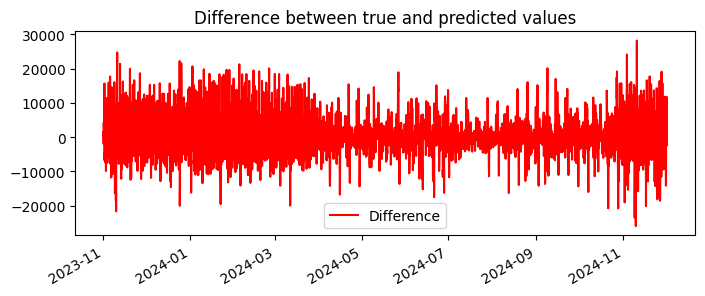

In [19]:
def evaluate(prediction, data, name):
    print(f"-- {name} --")
    print(f"mae: {mean_absolute_error(data, prediction)}")
    print(f"mse: {mean_squared_error(data, prediction)}")
    print(f"rmse: {root_mean_squared_error(data, prediction)}")

prediction = pd.read_csv('../Results/Whitebox/Forecasting/SARIMA_336_24.csv', header=None, index_col=0, names=['Prediction'])
prediction.index = pd.to_datetime(prediction.index)

data = df.tail(len(prediction))
difference = data['ConsumptionkWh'] - prediction['Prediction']

evaluate(prediction['Prediction'], data, 'SARIMA')

fig, ax = plt.subplots(figsize=(8, 3))
difference.plot(ax=ax, label='Difference', color='red')
ax.set_title('Difference between true and predicted values')
ax.legend()

Evaluate algorithm performance